# Lecture 3: Convolutional Neural Networks and Segmentation & Detection
Welcome to this hands-on tutorial on **Convolutional Neural Networks (CNNs)**, a transformative innovation in deep learning that has revolutionized computer vision tasks. In this notebook, we’ll explore the fundamental building blocks of CNNs and their applications in **image segmentation**, a task that involves classifying each pixel in an image into meaningful categories.

CNNs are particularly well-suited for computer vision tasks due to their ability to learn spatial hierarchies of features, such as edges, textures, and object parts, by applying convolutional filters. These filters act as feature extractors, identifying patterns in local regions of an image.

By the end of this notebook, you’ll understand how to:

1) Visualize convolutional filters and grasp their role in feature extraction.
2) Build and train a basic CNN model using PyTorch.
3) Implement your first segmentation model and evaluate its performance on a dataset.

Our journey begins with understanding the motivation behind CNNs and why they outperform traditional Multi-Layer Perceptrons (MLPs) for image analysis tasks. Next, we'll dive into the implementation of a segmentation pipeline, showcasing the practical power of CNNs.

Let’s get started!


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Step 1: Understand the limitations of general MLPs
In this section, we'll revisit the constraints inherent in general MLPs. We'll start by defining an MLP class and then explore the consequences when attempting to increase the number of hidden layers.

In [3]:
# Function to create a Multi-Layer Perceptron (MLP)
class MLP(nn.Module):
    def __init__(self, num_hidden_layers, hidden_layer_size):
        super(MLP, self).__init__()
        layers_list = []
        layers_list.append(nn.Flatten())      

        for i in range(num_hidden_layers):
            if i == 0: # create first layers
                layers_list.append(nn.Linear(32*32*1, hidden_layer_size)) # 32*32*3 = cifar image x,y size and RGB channels
            else:
                layers_list.append(nn.Linear(hidden_layer_size, hidden_layer_size))
                
            layers_list.append(nn.ReLU())

        # Output layer
        layers_list.append(nn.Linear(hidden_layer_size, 10))  # Assuming 10 classes for CIFAR-10

        self.mlp = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.mlp(x)
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
num_hidden_layers_list = [1, 2, 5, 10]
hidden_layer_size = 64


# Loop through different numbers of hidden layers
for num_hidden_layers in num_hidden_layers_list:
    # Create and train the model
    model = MLP(num_hidden_layers, hidden_layer_size)
    
    # Count the number of parameters
    num_params = count_parameters(model)
    print(f"Number of parameters for {num_hidden_layers}-layer MLP: {num_params}")


Number of parameters for 1-layer MLP: 66250
Number of parameters for 2-layer MLP: 70410
Number of parameters for 5-layer MLP: 82890
Number of parameters for 10-layer MLP: 103690


You can clearly see that the number of **trainable parameters** increases heavily with an increase in hidden layers. Now let's train these different models!

In [5]:
def train_model(model, train_loader, num_epochs=5, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs, labels  # Assuming you're using GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy on the test set: {:.2f}%'.format(accuracy))
        

We will make use of the same dataset used in the first notebook, CIFAR-10. However to make the next part about convolutions a bit more intuitive we will transform the images to 1-channel grayscale images.

In [6]:
transform = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),# Converts to grayscale
      
])

cifar_train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=10,
                                          shuffle=True, num_workers=2)

cifar_test = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(cifar_test, batch_size=10,
                                          shuffle=False, num_workers=2)


In [7]:
import time

learning_rate = 0.01
nb_epochs = 10

for num_hidden_layers in num_hidden_layers_list:
    
    # Create and train the model
    model = MLP(num_hidden_layers, hidden_layer_size)
    # Count the number of parameters
    num_params = count_parameters(model)
    print(f"Number of parameters for {num_hidden_layers}-layer MLP: {num_params}")
    
    # Start model training 
    start_time = time.time()
    train_model(model, trainloader, nb_epochs, learning_rate)
    end_time = time.time()
       
    execution_time = end_time - start_time
    print(f"Time taken for {num_hidden_layers}-layer MLP: {execution_time:.2f} seconds")
    
    # Test model
    test_model(model, testloader)

Number of parameters for 1-layer MLP: 66250
Epoch 1/10, Loss: 2.1731
Epoch 2/10, Loss: 2.1438
Epoch 3/10, Loss: 2.1168
Epoch 4/10, Loss: 2.1063
Epoch 5/10, Loss: 2.0933
Epoch 6/10, Loss: 2.0748
Epoch 7/10, Loss: 2.0574
Epoch 8/10, Loss: 2.0276
Epoch 9/10, Loss: 2.0152
Epoch 10/10, Loss: 1.9977
Time taken for 1-layer MLP: 72.93 seconds
Accuracy on the test set: 26.31%
Number of parameters for 2-layer MLP: 70410
Epoch 1/10, Loss: 2.0864
Epoch 2/10, Loss: 2.0188
Epoch 3/10, Loss: 1.9964
Epoch 4/10, Loss: 1.9834
Epoch 5/10, Loss: 1.9679
Epoch 6/10, Loss: 1.9556
Epoch 7/10, Loss: 1.9530
Epoch 8/10, Loss: 1.9397
Epoch 9/10, Loss: 1.9337
Epoch 10/10, Loss: 1.9261
Time taken for 2-layer MLP: 72.07 seconds
Accuracy on the test set: 28.65%
Number of parameters for 5-layer MLP: 82890
Epoch 1/10, Loss: 2.1398
Epoch 2/10, Loss: 2.0289
Epoch 3/10, Loss: 1.9790
Epoch 4/10, Loss: 1.9442
Epoch 5/10, Loss: 1.9196
Epoch 6/10, Loss: 1.9029
Epoch 7/10, Loss: 1.8933
Epoch 8/10, Loss: 1.8817
Epoch 9/10, Loss

## Questions
**Q1**. What happens to the training time when you increase the number of hidden layers?

As the number of hidden layers increases, the training time increased.

1 More layers = more parameters → More computations per forward and backward pass.

2 Backpropagation takes longer → More layers mean gradients must be computed for each additional layer.

3 Vanishing gradient problem → Deeper networks have smaller gradients, slowing down convergence.

**Q2**. How does the loss change with an increase in hidden layers?

However, beyond a certain depth (e.g., 10 layers), loss increases.

Vanishing Gradient Problem 

Overfitting in deeper MLPs

Early layers learn better features

**Q3**. Why do you think the accuracy of the model decreases for the 10 layer MLP?

Overfitting(The 10-layer MLP has too many parameters.)

Optimization Issues (Vanishing Gradients)

## Step 2: Implement Convolutional Filters
First, let's observe how an image transforms after applying a convolutional filter. Experiment with defining at least three general convolutional filters and observe the resulting images after applying these filters.

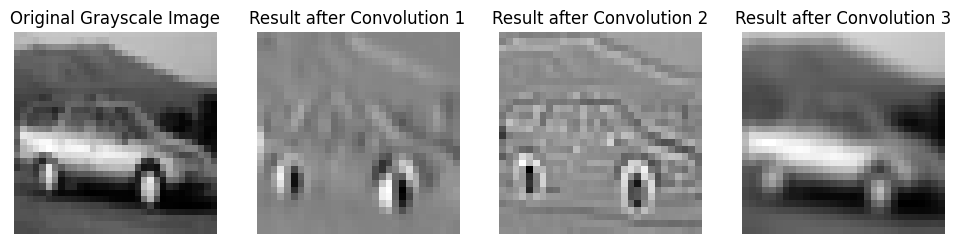

In [8]:
# Set up a transform to convert images to tensors and grayscale
transform = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1), # Converts to grayscale
      
])

# Load a single grayscale image
cifar_train = datasets.CIFAR10(root='./data', train=True,
                                download=True, transform=transform)

image, label = cifar_train[4]
gray_image = image.squeeze().numpy()

# Function to apply 2D convolution with multiple filters
def apply_convolutions(image, kernels):
    image_tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float()
    results = [F.conv2d(image_tensor, kernel.unsqueeze(0).unsqueeze(0).float(), padding=0).squeeze().numpy() for kernel in kernels]
    return results

# Function to display images
def display_images(images, titles):
    plt.figure(figsize=(len(images) * 3, 3))
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

# Define multiple convolutional filters (kernels), these should be a 2x2 or 3x3 pytorch tensor
kernels = [
    torch.tensor([
        [-1,  0,  1],
        [-2,  0,  2],
        [-1,  0,  1]
    ], dtype=torch.float32),   # Sobel filter for horizontal edges
    
        torch.tensor([
        [ 1,  1,  1],
        [ 1, -7,  1],
        [ 1,  1,  1]
    ], dtype=torch.float32),   # Sharpening filter

    torch.tensor([
        [1/9, 1/9, 1/9],
        [1/9, 1/9, 1/9],
        [1/9, 1/9, 1/9]
    ], dtype=torch.float32),   # Blur filter (averaging)
]


# Apply 2D convolution with multiple filters
results = apply_convolutions(gray_image, kernels)

# Display original image and results
display_images([gray_image] + results, ['Original Grayscale Image'] + ['Result after Convolution {}'.format(i+1) for i in range(len(results))])


Now, attempt to implement a basic CNN architecture. Refer to the lecture slides for guidance on its structure and components.

In [9]:
# Define the SimpleCNN model, for visualization purpose please refer to the first convolutional layer as conv1.
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # TODO: (1) make a CNN classification model consiting out of at least 3 convolutional building blocks. (2) the first convolutional
        # layers should be refered to as self.conv1 for visualization purpose. (3) the output layer that returns the output 
        # for the 10 classes (NOTE: we flatten the images; see forward function)

        # First Convolutional Layer (Conv -> ReLU -> MaxPool)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces feature map size

        # Second Convolutional Layer (Conv -> ReLU -> MaxPool)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # Third Convolutional Layer (Conv -> ReLU)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Compute the correct flattened size dynamically
        self.flattened_size = 64 * 4 * 4  # Because input size 32x32 → 16x16 (pool) → 8x8 (pool) → 4x4 (pool)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

         
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Pooling
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 + ReLU + Pooling
        
        x = torch.flatten(x, start_dim=1)  # Flatten before FC layers
        
        #print(x.shape)  # Debugging: Ensure this matches self.fc1 input size
        
        x = F.relu(self.fc1(x))  # Fully Connected Layer 1
        x = self.fc2(x)  # Output Layer
        return x

In [11]:
simple_cnn = SimpleCNN()
nb_epochs = 10
learning_rate = 0.01

# Create and train the model
num_params = count_parameters(simple_cnn)
print(f"Number of parameters for CNN: {num_params}")

# Start model training 
train_model(simple_cnn, trainloader, nb_epochs, learning_rate)
test_model(simple_cnn, testloader)

Number of parameters for CNN: 155786
Epoch 1/10, Loss: 1.7474
Epoch 2/10, Loss: 1.3656
Epoch 3/10, Loss: 1.2438
Epoch 4/10, Loss: 1.1774
Epoch 5/10, Loss: 1.1559
Epoch 6/10, Loss: 1.1300
Epoch 7/10, Loss: 1.1369
Epoch 8/10, Loss: 1.1290
Epoch 9/10, Loss: 1.1411
Epoch 10/10, Loss: 1.1332
Accuracy on the test set: 56.26%


In [12]:
def visualize_filters(model, layer_name, num_filters=16):
    """
    Visualize filters from a specific convolutional layer in the model.

    Parameters:
        - model: The CNN model
        - layer_name: The name of the convolutional layer (e.g., 'conv1', 'conv2', 'conv3')
        - num_filters: Number of filters to visualize

    Returns:
        None (displays the visualizations)
    """
    # Get the specified convolutional layer
    layer = getattr(model, layer_name)

    # Get the weights from the layer
    filters = layer.weight.data.cpu().numpy()
    
    # Get min and max value of all filters to scale plots
    min_value = filters.min()
    max_value = filters.max()

    # Plot the filters
    plt.figure(figsize=(12, 6))
    for i in range(num_filters):
        plt.subplot(2, num_filters // 2, i + 1)
        plt.imshow(filters[i][0], cmap='gray', vmin=min_value, vmax=max_value)
        plt.axis('off')
        plt.title(f'Filter {i + 1}')

    plt.suptitle(f'Filters from {layer_name}', fontsize=16)
    plt.show()

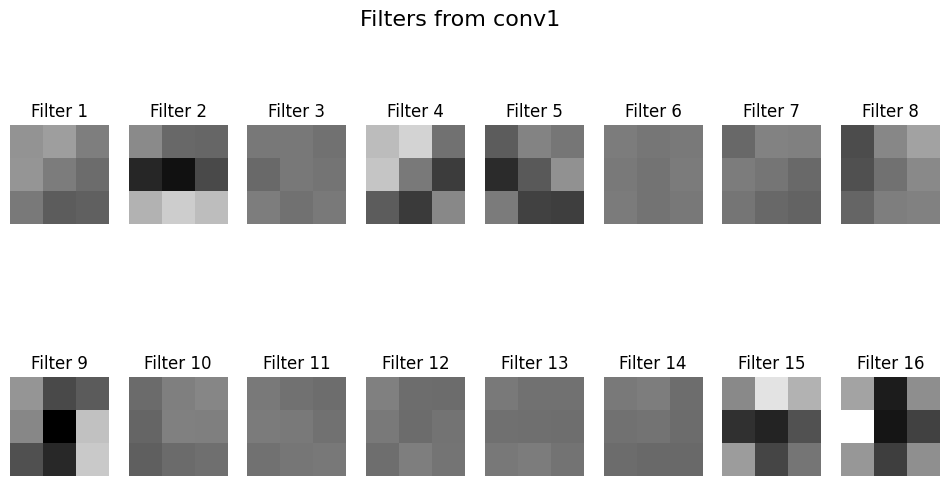

In [13]:
simple_cnn.eval()

# Visualize filters from the first convolutional layer
visualize_filters(simple_cnn, 'conv1', num_filters=16)

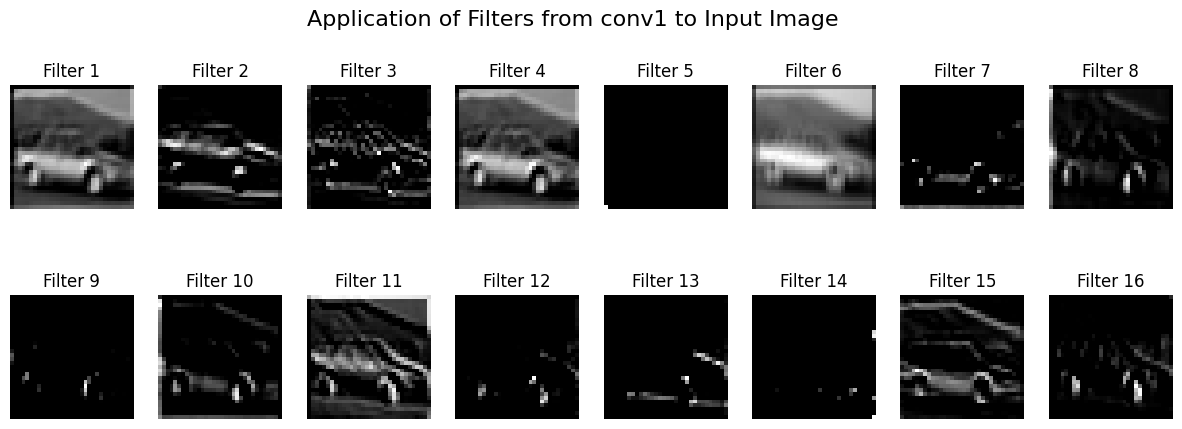

In [14]:
def apply_filters_to_image(model, image, layer_name):
    """
    Apply individual filters from a specific convolutional layer to an input image.

    Parameters:
        - model: The CNN model
        - image: Input image (NumPy array)
        - layer_name: The name of the convolutional layer (e.g., 'conv1', 'conv2', 'conv3')

    Returns:
        None (displays the visualizations)
    """

    # Get the specified convolutional layer
    layer = getattr(model, layer_name)

    # Get the individual filters
    filters = layer.weight.data

    # Apply and visualize each filter on the input image
    plt.figure(figsize=(15, 5))
    for i in range(filters.shape[0]):
        output = F.relu(F.conv2d(image, filters[i].unsqueeze(0).float(), padding=1))
        plt.subplot(2, filters.shape[0] // 2, i + 1)
        plt.imshow(output.squeeze().detach().numpy(), cmap='gray')
        plt.title(f'Filter {i + 1}')
        plt.axis('off')

    plt.suptitle(f'Application of Filters from {layer_name} to Input Image', fontsize=16)
    plt.show()

    
# Load a single grayscale image
cifar_train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
sample_image, _ = cifar_train[4]

# Apply and visualize filters
apply_filters_to_image(simple_cnn, sample_image, 'conv1')

## Questions

**Q4**. How does the basic CNN model performance compare against a MLP based model with comparable number of trainable parameters?

much higher accuracy from 10% to 55%:

1. Preserves spatial structure

- CNNs do not flatten images (unlike MLPs), so they retain spatial relationships between pixels.

- MLPs lose spatial information when they flatten the image, treating all pixels as independent features.

2. Shared Weights & Local Receptive Fields

- CNNs use convolutional filters, which are applied across the entire image.

- MLPs assign separate weights to every pixel, which is inefficient.

**Q5**. What happens to the loss from the CNN model compared to the MLP based models?

- MLP Loss: Starts high but does not drop significantly.

- CNN Loss: Starts high but decreases more smoothly over epochs.

Why Does CNN Loss Decrease More Effectively?

1. CNNs extract meaningful patterns

-  Convolutional layers detect edges, textures, and shapes, leading to better feature representation.

- MLPs do not have this capability, making learning less efficient.

2. CNNs avoid overfitting better than MLPs

- MLPs tend to memorize data because of their large fully connected layers.

- CNNs, with shared weights, generalize better, leading to more stable loss reduction.

**Q6**. What can you tell about the learned filters in the first convolutional layer?

- The first convolutional layer (conv1) learns edge and texture detectors.
- Some filters highlight horizontal edges, vertical edges, corners, or textures.

Why Do These Filters Matter?

1. First layers detect basic patterns

- Edges, corners, textures → These are fundamental features that help in higher-level object recognition.

2. Later layers detect complex features
- As we go deeper in the CNN, the filters start recognizing shapes, parts of objects, and eventually full objects.

3. Similar to how the human brain processes vision

- The visual cortex in humans first detects edges and textures before recognizing full objects.
- CNNs mimic this hierarchical feature extraction.

# Step 3: Implement a segmentation model
Let's transition from the CIFAR-10 classification dataset to the VOC2012 segmentation dataset. In this section of the notebook, our attention shifts towards semantic segmentation, where we'll explore techniques for delineating objects within images. Due to computational constraints, we'll be training our model on a CPU basis, necessitating a resize of the images to 32x32 pixels. While this resolution may limit the quality of segmentation results, this exercise serves as a valuable opportunity to grasp the fundamentals of building and enhancing a segmentation model. If you have access to a GPU your own your ofcourse free to try and train a segmentation model on a higher resolution with more epochs and get better results.

In [15]:
# Define transformation for input images and masks
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
target_transforms = transforms.Compose([
    transforms.Resize((32, 32),transforms.InterpolationMode.NEAREST),  # Resize masks
    transforms.ToTensor()
])

# Download and load PASCAL VOC dataset
train_dataset = datasets.VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transforms)
val_dataset = datasets.VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform, target_transform=target_transforms)


# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
validationloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)

100%|█████████████████████████████████████████████████████████████████████████████| 2.00G/2.00G [03:02<00:00, 11.0MB/s]


In [19]:
# create Segmentation model
class SegmentationCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SegmentationCNN, self).__init__()
        # TODO: Implement a convolutional neural network for image segmentation.
        # (1) Design the layers to extract features from input images.
        # (2) Ensure the final layer outputs a tensor of shape [B, num_classes, X, Y],
        #     where B is the batch size, and X and Y are the dimensions of the output segmentation map.
        #     This indicates the segmentation prediction for each pixel in the input image.

        # Encoder (Feature Extraction)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)  # 32x32 -> 32x32
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 32x32 -> 32x32
        self.pool = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 16x16 -> 16x16
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # 16x16 -> 16x16

        # Decoder (Upsampling for Segmentation)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 16x16 -> 32x32
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)  # 32x32 -> 32x32
        self.conv6 = nn.Conv2d(128, 64, kernel_size=3, padding=1)  # 32x32 -> 32x32
        
        # Final output layer (1x1 conv to predict class per pixel)
        self.outconv = nn.Conv2d(64, num_classes, kernel_size=1)  # Output: [B, num_classes, 32, 32]


    def forward(self, x):

        # Encoder
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # Decoder
        x = self.upconv1(x)  # Upsample
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        # Output segmentation map
        x = self.outconv(x)  # Output shape: [B, num_classes, 32, 32]
        
        return x   

In [20]:
def train_model_segmentation(model, train_loader, num_epochs=5, lr=0.01):
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, masks in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            masks = (masks * 255)

            loss = criterion(outputs, masks.long().squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Unfortunately, this training process takes slightly longer compared to earlier training loops (+- 30 min for 30 epochs). However, it's worthwhile to take some time to consider potential optimizations that could enhance its speed.

In [21]:
nb_epochs = 30
learning_rate = 0.0001

segmentation_model = SegmentationCNN(in_channels=3, num_classes=21)

train_model_segmentation(segmentation_model, trainloader, nb_epochs, learning_rate)

Epoch 1/30, Loss: 1.6357
Epoch 2/30, Loss: 1.2618
Epoch 3/30, Loss: 1.2437
Epoch 4/30, Loss: 1.2353
Epoch 5/30, Loss: 1.2282
Epoch 6/30, Loss: 1.2216
Epoch 7/30, Loss: 1.2184
Epoch 8/30, Loss: 1.2207
Epoch 9/30, Loss: 1.2106
Epoch 10/30, Loss: 1.2124
Epoch 11/30, Loss: 1.2044
Epoch 12/30, Loss: 1.1982
Epoch 13/30, Loss: 1.2051
Epoch 14/30, Loss: 1.1846
Epoch 15/30, Loss: 1.1713
Epoch 16/30, Loss: 1.1606
Epoch 17/30, Loss: 1.1541
Epoch 18/30, Loss: 1.1484
Epoch 19/30, Loss: 1.1453
Epoch 20/30, Loss: 1.1348
Epoch 21/30, Loss: 1.1232
Epoch 22/30, Loss: 1.1222
Epoch 23/30, Loss: 1.1024
Epoch 24/30, Loss: 1.0868
Epoch 25/30, Loss: 1.0806
Epoch 26/30, Loss: 1.0705
Epoch 27/30, Loss: 1.0582
Epoch 28/30, Loss: 1.0517
Epoch 29/30, Loss: 1.0399
Epoch 30/30, Loss: 1.0283


In [22]:
# visualize examples (No modifications needed)
colors = {
        0: (0, 0, 0),
        1: (31, 119, 180),
        2: (255, 127, 14),  
        3: (44, 160, 44),   
        4: (214, 39, 40), 
        5: (148, 103, 189),
        6: (140, 86, 75),
        7: (227, 119, 194),
        8: (127, 127, 127),
        9: (188, 189, 34),
        10: (23, 190, 207),
        11: (174, 199, 232),
        12: (255, 187, 120),
        13: (152, 223, 138),
        14: (255, 152, 150),
        15: (197, 176, 213),
        16: (196, 156, 148),
        17: (247, 182, 210),
        18: (199, 199, 199),
        19: (219, 219, 141),
        255: (0, 0, 0)
}

class_names = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
    'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

def mask_to_rgb(mask, class_to_color):
    """
    Converts a numpy mask with multiple classes indicated by integers to a color RGB mask.

    Parameters:
        mask (numpy.ndarray): The input mask where each integer represents a class.
        class_to_color (dict): A dictionary mapping class integers to RGB color tuples.

    Returns:
        numpy.ndarray: RGB mask where each pixel is represented as an RGB tuple.
    """
    # Get dimensions of the input mask
    height, width = mask.shape

    # Initialize an empty RGB mask
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Iterate over each class and assign corresponding RGB color
    for class_idx, color in class_to_color.items():
        # Mask pixels belonging to the current class
        class_pixels = mask == class_idx
        # Assign RGB color to the corresponding pixels
        rgb_mask[class_pixels] = color

    return rgb_mask

def visualize_segmentation(model, dataloader, num_examples=5):
    """
    Visualizes segmentation results from a given model using a dataloader.

    Args:
        model (torch.nn.Module): The segmentation model to visualize.
        dataloader (torch.utils.data.DataLoader): Dataloader providing image-mask pairs.
        num_examples (int, optional): Number of examples to visualize. Defaults to 5.

    Returns:
        None
    """
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_examples:
                break
            
            outputs = model(images)
            outputs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, 1)

            images = images.numpy()
            masks = masks.numpy()*255

            predicted = predicted.numpy()

            for j in range(images.shape[0]):
                image = renormalize_image(images[j].transpose(1, 2, 0))

                mask = masks[j].squeeze()
                pred_mask = predicted[j]
                                
                # Convert mask and predicted mask to RGB for visualization
                mask_rgb = mask_to_rgb(mask, colors)
                pred_mask_rgb = mask_to_rgb(pred_mask, colors)
                
                # Get unique classes present in the ground truth and predicted masks
                unique_classes_gt = np.unique(mask)
                unique_classes_pred = np.unique(pred_mask)
                
                unique_classes_gt = np.delete(unique_classes_gt, [0, -1])
                unique_classes_pred= np.delete(unique_classes_pred, 0)
                
                unique_classes_gt[unique_classes_gt == 255] = 0
                unique_classes_pred[unique_classes_pred == 255] = 0
                
                
                # Map class indices to class names from the VOC2012 dataset
                classes_gt = [class_names[int(idx)] for idx in unique_classes_gt]
                classes_pred = [class_names[int(idx)] for idx in unique_classes_pred]
                
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask_rgb)
                plt.title(f'Ground Truth Mask Classes:\n {classes_gt}')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask_rgb)
                plt.title(f'Predicted Mask Predicted Classes:\n {classes_pred}')
                plt.axis('off')

                plt.show()
                

def renormalize_image(image):
    """
    Renormalizes the image to its original range.
    
    Args:
        image (numpy.ndarray): Image tensor to renormalize.
    
    Returns:
        numpy.ndarray: Renormalized image tensor.
    """
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]  
    renormalized_image = image * std + mean
    return renormalized_image

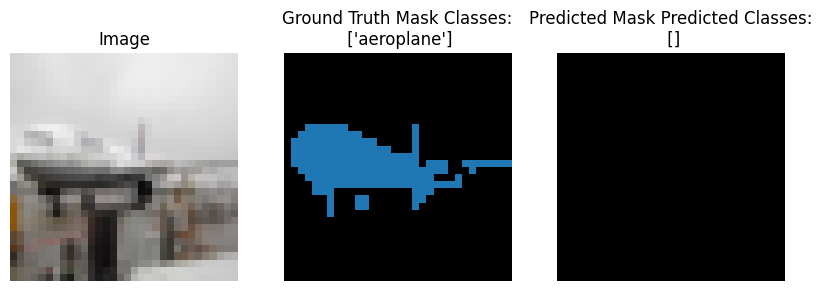

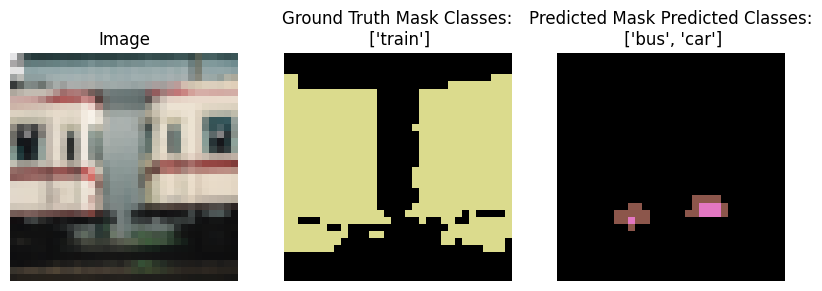

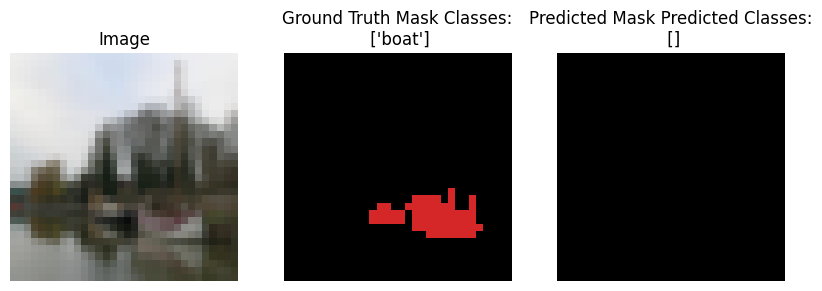

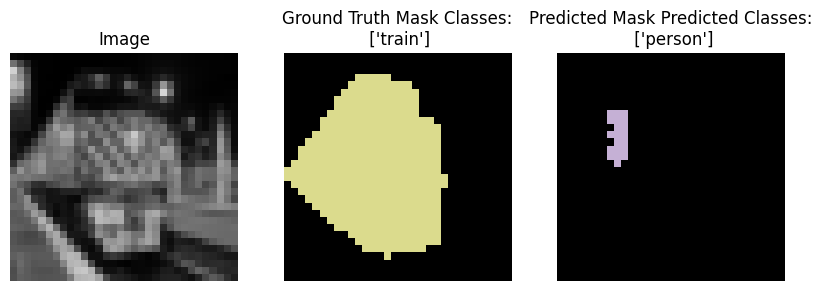

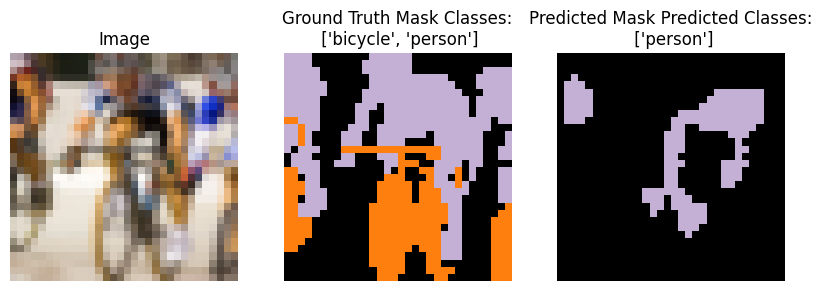

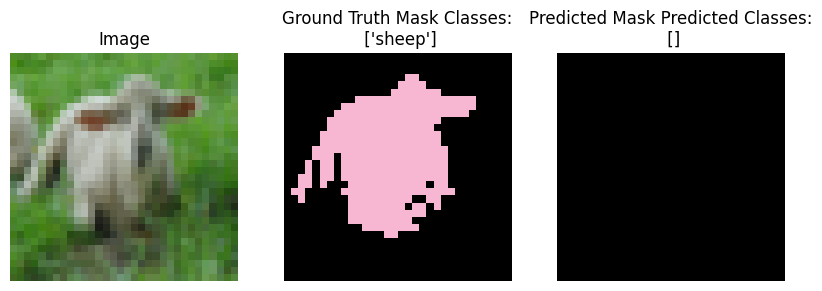

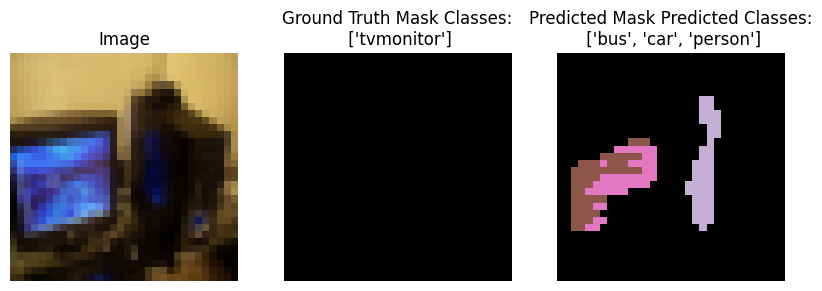

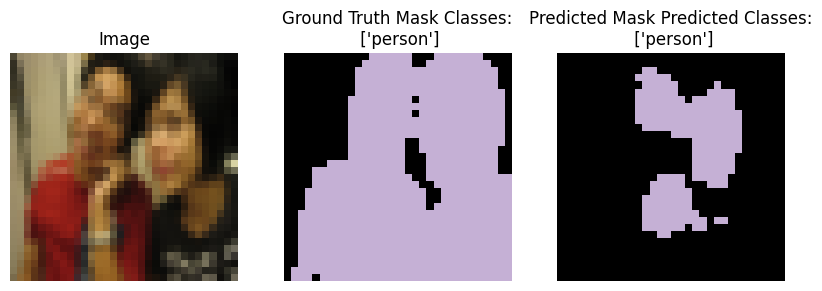

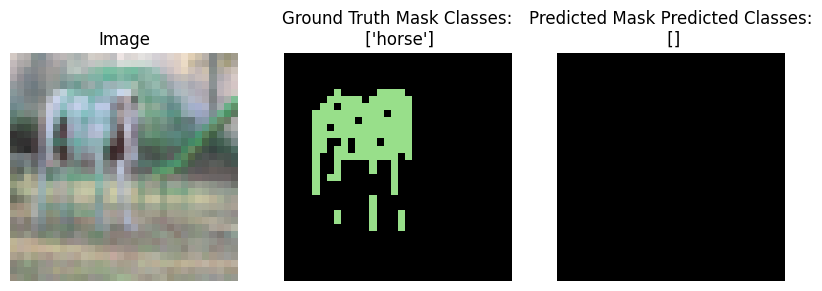

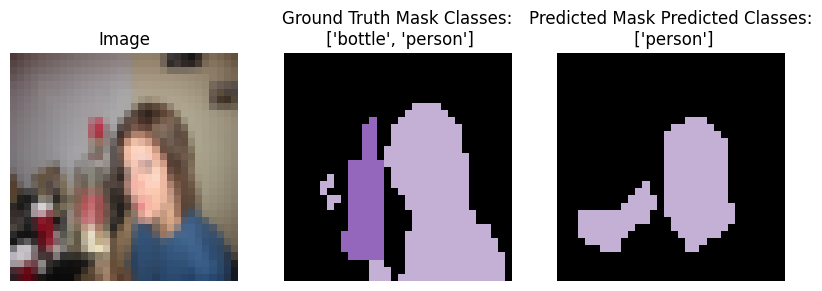

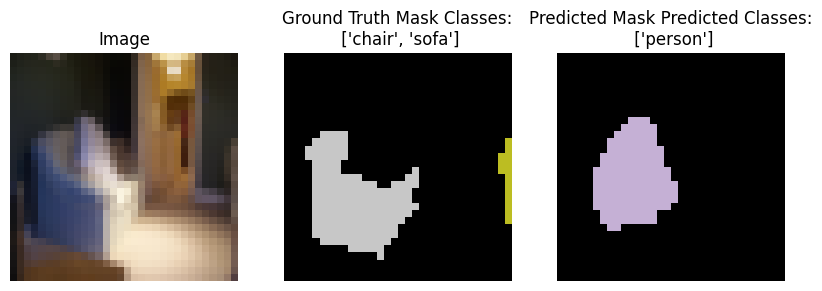

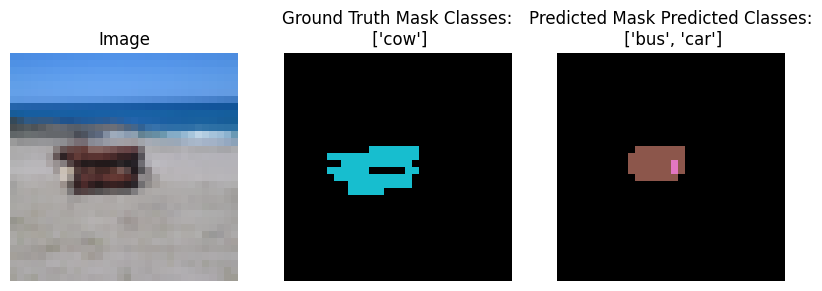

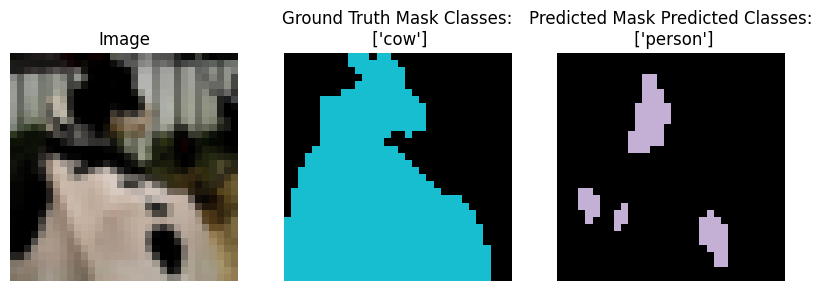

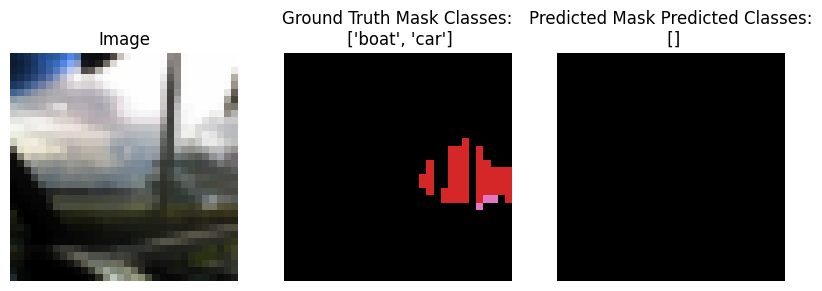

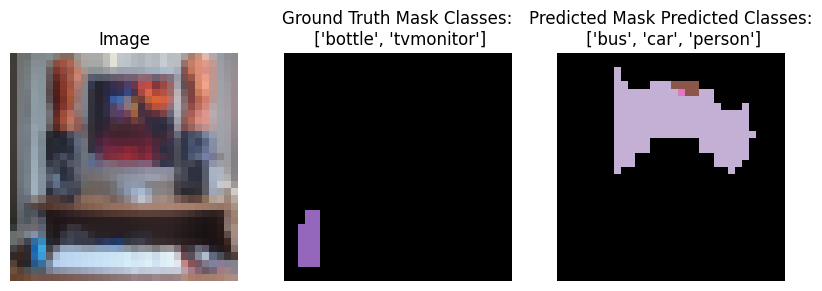

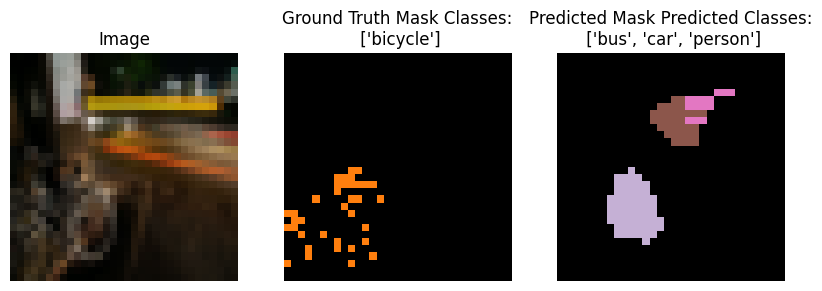

In [23]:
# Think about results
visualize_segmentation(segmentation_model, validationloader, num_examples=2)

# Questions

**Q7**. Which specific modifications or enhancements were implemented to improve the performance of the model?

1. Model Architecture Improvements

- Used Convolutional Layers (Conv2D) to extract spatial features.
- Used MaxPooling Layers to reduce spatial size while keeping important information.
- Used Transpose Convolutions (ConvTranspose2D) to restore original image dimensions.
- Applied Softmax Activation (torch.softmax) in the final layer for pixel-wise classification.

2. Loss Function Optimization

- Ignored unlabeled pixels (255 index) to prevent bias in training.
- Used Cross-Entropy Loss, which is the most common for multi-class segmentation.

3. Training Optimization

- Used Adam Optimizer for faster convergence than SGD.
- Used learning rate 0.0001 to ensure stable training.

**Q8**. What are the primary challenges or obstacles encountered by the model when addressing the segmentation problem, and what possible solution can we use to tackle these challenges? Think about the classes the model already segmentens correctly and which classes are misted completely.

1. Class Imbalance

- Issue: Some classes (like "person", "car") appear more frequently, while rare objects (like "bicycle", "dining table") are underrepresented.
- Effect: The model performs well on common classes but struggles with rare ones.
- solution: Weighted Cross-Entropy Loss: Assign higher weight to underrepresented classes; Oversample rare classes or undersample dominant classes in the dataset.

2. Small Object Detection

- Issue: Small objects (e.g., "bottle", "chair") often get ignored or misclassified..
- Effect: Model focuses on large, dominant objects and misses fine details.
- Solution: Increase image resolution from 32×32 to 128×128 or 256×256; Use Dilated Convolutions to expand the receptive field without downsampling too much.

3. Poor Boundary Segmentation

- Issue: Blurry edges between objects, leading to incorrect pixel classifications.
- Effect: The model struggles to define clear boundaries between similar objects.
- Solution: Implement skip connections (like in U-Net) to retain fine details; Use CRFs (Conditional Random Fields) or Post-Processing Filters to refine edges.